In [1]:
import numpy as np
import doubleml as dml
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from doubleml.datasets import make_plr_CCDDHNR2018, make_irm_data
from sklearn.base import clone

from scipy import stats

from utils import make_data_list, simulate_gb_plr, make_BCH2014_data_list

np.random.seed(1312)

# 1. Create Data

## 1.1 DGB based on CCDDHNR2018

In [2]:
n_rep = 1000
n_obs = 500
n_vars = 20
alpha = 0.5

data = make_data_list(n_rep=n_rep, n_obs=n_obs, n_vars=n_vars, model_type='plr', alpha=alpha)

## 1.2 DGB based on BCH2014

In [3]:
n_rep_BCH14 = 300
theta_BCH14 = 0.5 
n_obs_BCH14 = 100
dim_x_BCH14 = 200 
rho_BCH14 = 0.5
R2_d_BCH14 = 0.5 
R2_y_BCH14 = 0.5 
design_BCH14 = '1a'

random_seed_BCH14 = 1312

data_BCH14 = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_BCH14, dim_x=dim_x_BCH14,
                                    rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

# 2. Finding Optimal Hyperparameter Combination

## 2.1 Gradient Boosting Regressor (PLR)

In [4]:
gb_regression_hyperparameters = dict(
    loss = ['squared_error', 'huber', 'quantile'],
    learning_rate = [0.001, 0.01, 0.1, 1],
    n_estimators = [10, 100, 1000],
    subsample = [0.9, 1],
    min_samples_split = [0.01, 0.1, 0.5],
    min_samples_leaf = [2, 5, 10]
)

np.random.seed(1312)

(x, y, d) = make_plr_CCDDHNR2018(n_obs=n_obs, n_vars=n_vars, return_type='array')
search_dml_plr_data = dml.DoubleMLData.from_arrays(x, y, d)

ml_l = GradientBoostingRegressor()
ml_m = GradientBoostingRegressor()

dml_gb_regression = {
    "ml_l": gb_regression_hyperparameters,
    "ml_m": gb_regression_hyperparameters
}

gb_dml_plr_obj = dml.DoubleMLPLR(
    search_dml_plr_data, ml_l, ml_m, n_folds=5,
    score='partialling out', apply_cross_fitting=True
)

# using DoubleML tune() method for grid/randomized search
gb_dml_plr_obj.tune(dml_gb_regression, search_mode='randomized_search')
print(gb_dml_plr_obj.fit(store_models=True).summary)

       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.529257  0.038088  13.895736  6.722895e-44  0.454607  0.603908


In [5]:
ml_l_plr_model_list = gb_dml_plr_obj.models['ml_l']['d'][0]
ml_l_plr_gb_model = max(set(ml_l_plr_model_list), key=ml_l_plr_model_list.count)
ml_m_plr_model_list = gb_dml_plr_obj.models['ml_m']['d'][0]
ml_m_plr_gb_model = max(set(ml_m_plr_model_list), key=ml_l_plr_model_list.count)

print(f"ml_l model: {ml_l_plr_gb_model}\nml_m model: {ml_m_plr_gb_model}")

ml_l model: GradientBoostingRegressor(learning_rate=0.01, loss='huber', min_samples_leaf=10,
                          min_samples_split=0.5, n_estimators=1000,
                          subsample=0.9)
ml_m model: GradientBoostingRegressor(loss='huber', min_samples_leaf=5,
                          min_samples_split=0.5, subsample=0.9)


## 2.2 Gradient Boosting Classifier (IRM)

In [6]:
gb_classification_hyperparameters = dict(
    loss = ['log_loss', 'exponential'],
    learning_rate = [0.001, 0.01, 0.1, 1],
    n_estimators = [10, 100, 1000],
    subsample = [0.9, 1],
    min_samples_split = [0.01, 0.1, 0.5],
    min_samples_leaf = [2, 5, 10]
)

np.random.seed(1312)

(x, y, d) = make_irm_data(n_obs=n_obs, dim_x=n_vars, return_type='array')
search_dml_irm_data = dml.DoubleMLData.from_arrays(x, y, d)

ml_l = GradientBoostingRegressor()
ml_m = GradientBoostingClassifier()

dml_gb_classification = {
    "ml_g": gb_regression_hyperparameters,
    "ml_m": gb_classification_hyperparameters
}

gb_dml_irm_obj = dml.DoubleMLIRM(
    search_dml_irm_data, ml_l, ml_m, n_folds=5,
    score='ATE', apply_cross_fitting=True
)

# using DoubleML tune() method for grid/randomized search
gb_dml_irm_obj.tune(dml_gb_classification, search_mode='randomized_search')
print(gb_dml_irm_obj.fit(store_models=True).summary)

       coef   std err         t     P>|t|     2.5 %    97.5 %
d  0.263386  0.090921  2.896858  0.003769  0.085184  0.441588


In [7]:
ml_g0_irm_model_list = gb_dml_irm_obj.models['ml_g0']['d'][0]
ml_g0_irm_gb_model = max(set(ml_g0_irm_model_list), key=ml_g0_irm_model_list.count)
ml_g1_irm_model_list = gb_dml_irm_obj.models['ml_g1']['d'][0]
ml_g1_irm_gb_model = max(set(ml_g1_irm_model_list), key=ml_g1_irm_model_list.count)
ml_m_irm_model_list = gb_dml_irm_obj.models['ml_m']['d'][0]
ml_m_irm_gb_model = max(set(ml_m_irm_model_list), key=ml_m_irm_model_list.count)

print(f"ml_g0 model: {ml_g0_irm_gb_model}\nml_g1 model: {ml_g1_irm_gb_model}\nml_m model: {ml_m_irm_gb_model}")

ml_g0 model: GradientBoostingRegressor(loss='huber', min_samples_leaf=2,
                          min_samples_split=0.5, n_estimators=10, subsample=1)
ml_g1 model: GradientBoostingRegressor(loss='huber', min_samples_leaf=5,
                          min_samples_split=0.01, n_estimators=10,
                          subsample=0.9)
ml_m model: GradientBoostingClassifier(learning_rate=0.01, loss='exponential',
                           min_samples_leaf=2, min_samples_split=0.5,
                           subsample=1)


# 3. PLR Simulation and Hyperparameter Variation

## 3.1 Number of Estimators Variation

In [8]:
def plot_gradient_boosting_score(ml_l, ml_m, theta_scores, se_scores, alpha, hyperparameter: str):
    
    face_colors = sns.color_palette('pastel')
    edge_colors = sns.color_palette('dark')

    plt.figure(constrained_layout=True)
    plt.title(f'Gradient Boosting: \n' + f'${hyperparameter}' + '_{m_{0}(x)}$' + f'={ml_m.n_estimators}'
            '\n' + f'${hyperparameter}' + '_{g_{0}(x)}$' + f'={ml_l.n_estimators}')
    ax = sns.histplot((theta_scores - alpha)/se_scores,
                    color=face_colors[2], edgecolor = edge_colors[2],
                    stat='density', bins=30, label='Double ML GB')
    ax.axvline(0., color='k')

    xx = np.arange(-5, +5, 0.001)
    yy = stats.norm.pdf(xx)

    ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax.set_xlim([-6., 6.])
    ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')
    plt.show()

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


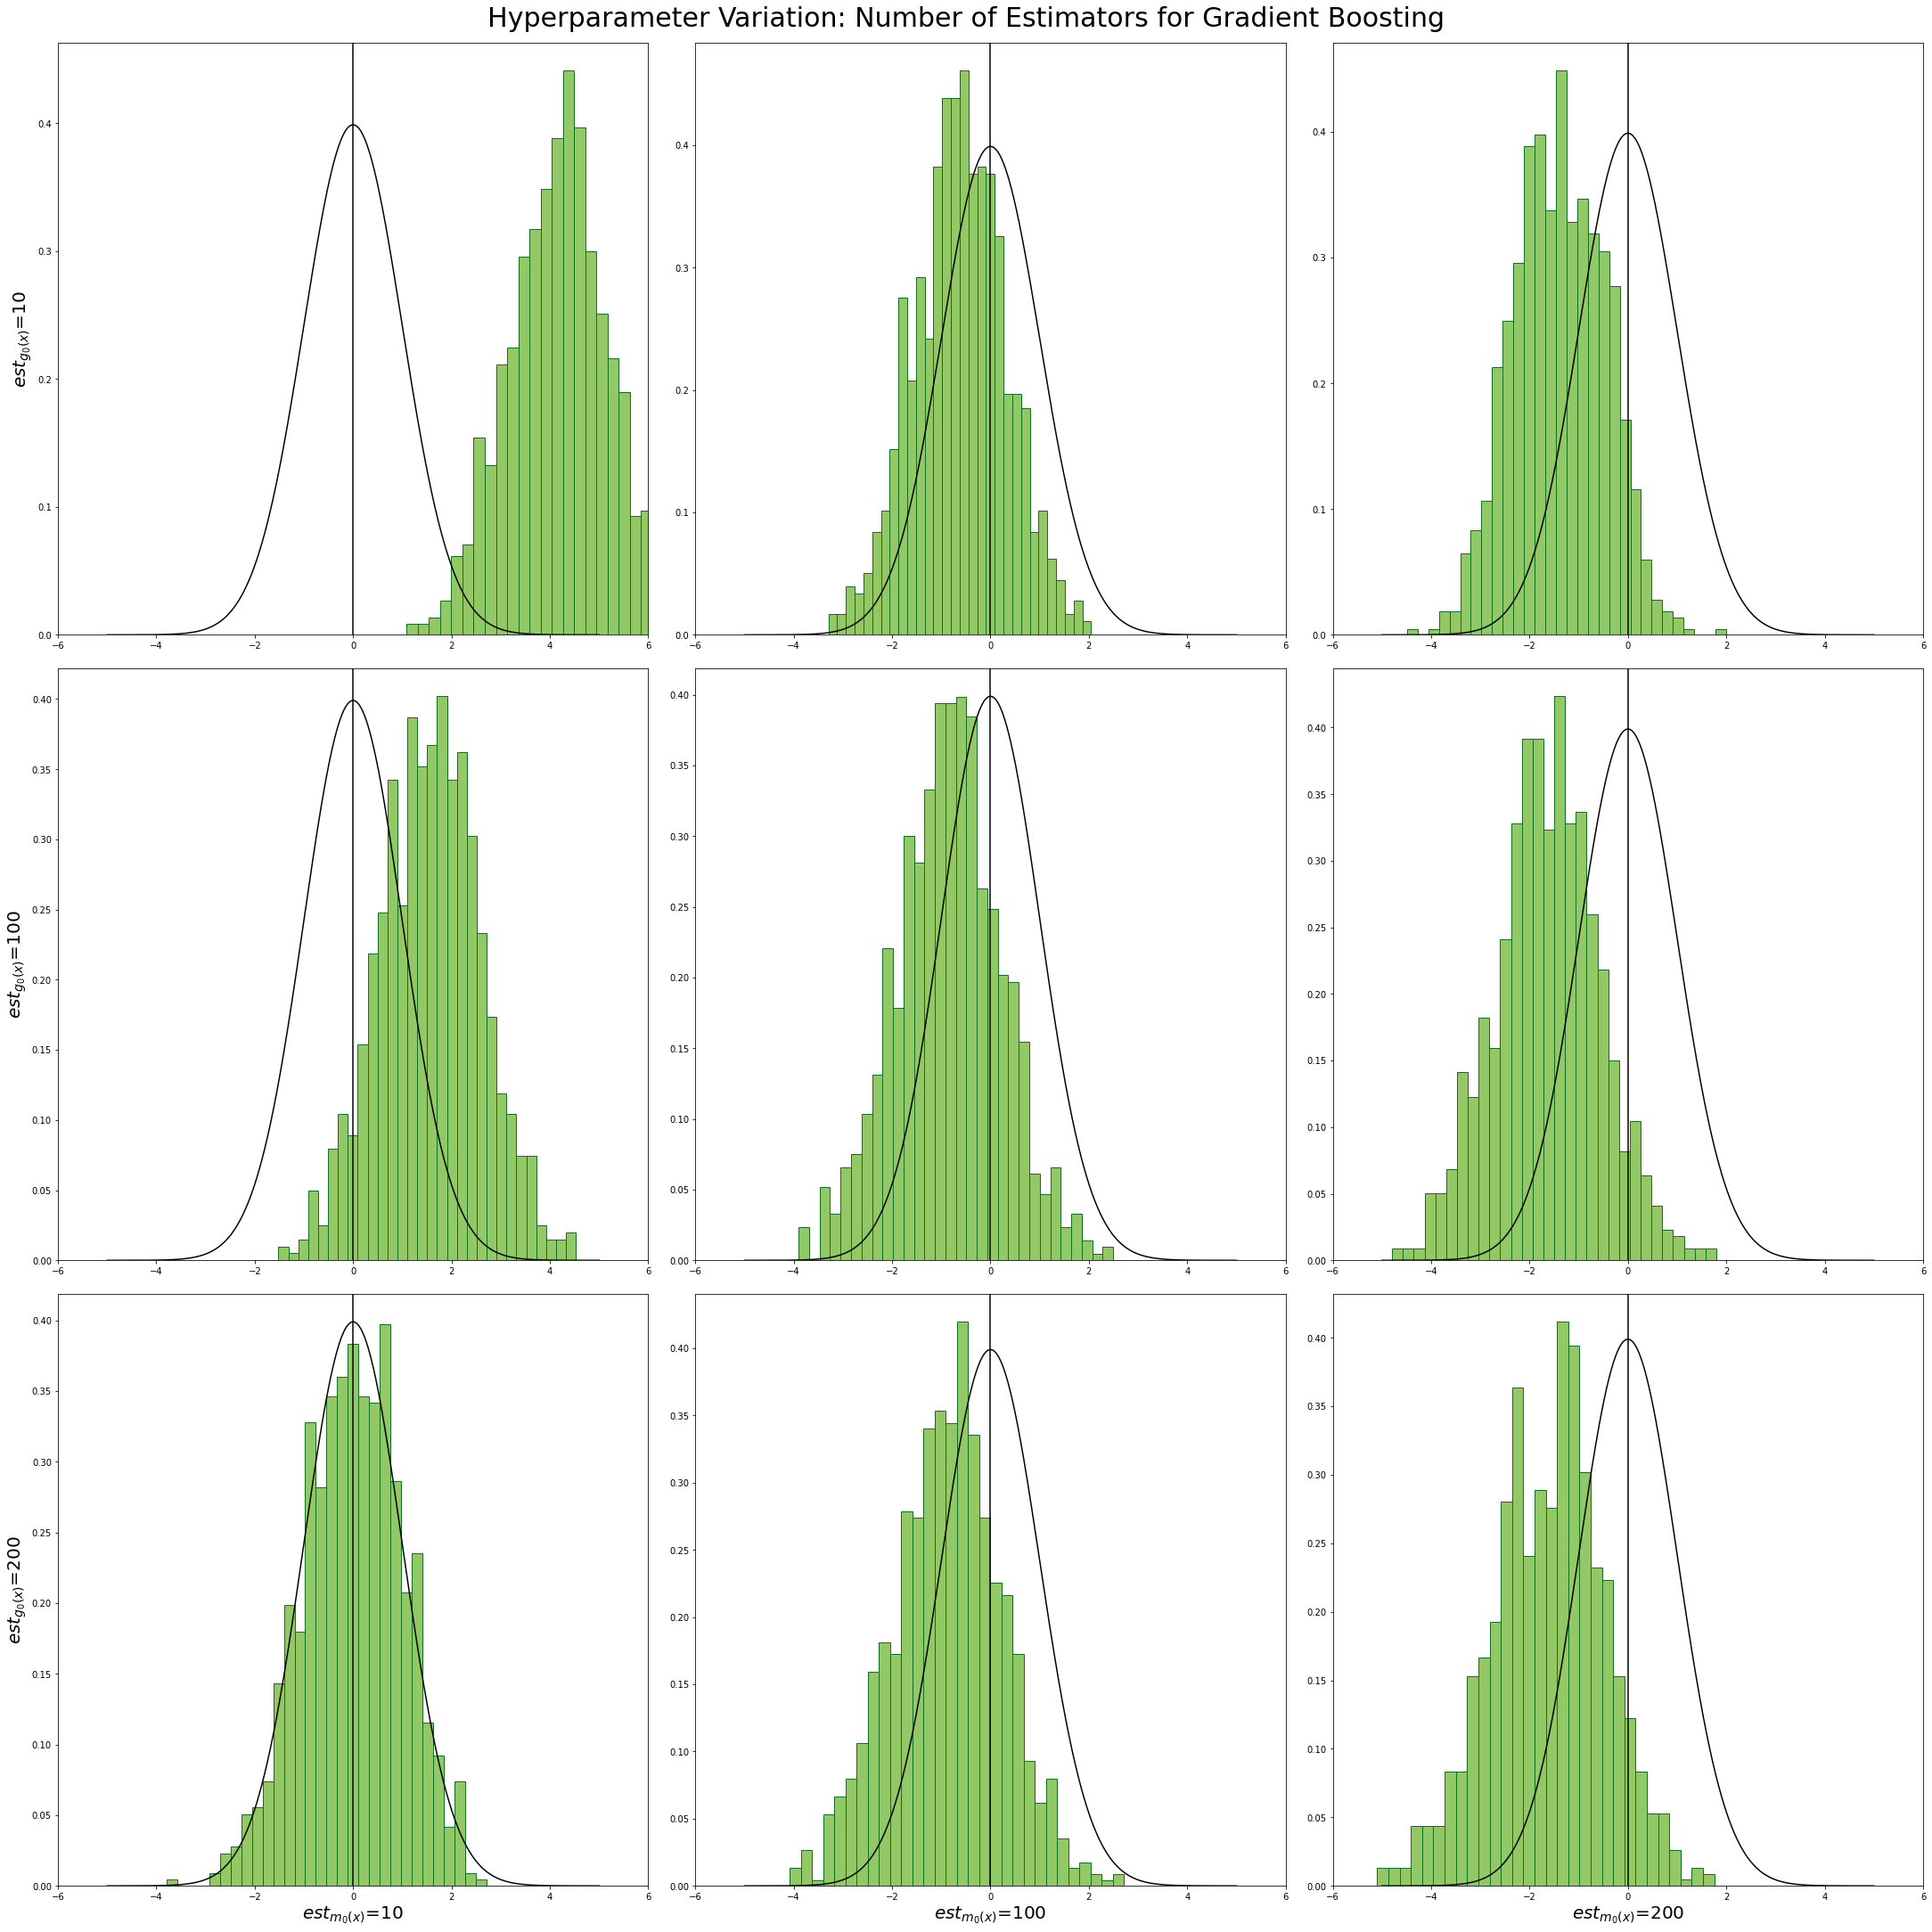

In [9]:
face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

gb_n_est_hyperparams_ml_l = [10, 100, 200]
gb_n_est_hyperparams_ml_m = [10, 100, 200]
n_folds = 2

scores = []
distributions_calculated = 1

fig, axs = plt.subplots(len(gb_n_est_hyperparams_ml_l), len(gb_n_est_hyperparams_ml_m), 
                        figsize=(10*len(gb_n_est_hyperparams_ml_l), 10*len(gb_n_est_hyperparams_ml_m)), 
                        constrained_layout=True)

fig.suptitle("Hyperparameter Variation: Number of Estimators for Gradient Boosting", fontsize=30)

for ml_l_param in gb_n_est_hyperparams_ml_l:
    for ml_m_param in gb_n_est_hyperparams_ml_m:

        i_m = gb_n_est_hyperparams_ml_m.index(ml_m_param)
        i_l = gb_n_est_hyperparams_ml_l.index(ml_l_param)

        ml_l = clone(ml_l_plr_gb_model).set_params(**{'n_estimators': ml_l_param})
        ml_m = clone(ml_m_plr_gb_model).set_params(**{'n_estimators': ml_m_param})
        
        theta_scores, se_scores, _ = simulate_gb_plr(ml_l=ml_l, ml_m=ml_m, n_folds=n_folds, data=data, score='partialling out')

        scores.append((theta_scores, se_scores, f"ml_l-n_est: {ml_l_param}", f"ml_m-n_est: {ml_m_param}"))

        print(f"Distributions calculated: {distributions_calculated}")
        
        axs[i_l, i_m].hist((theta_scores - alpha)/se_scores,
                            color=face_colors[2], edgecolor = edge_colors[2],
                            density=True, bins=30, label='Double ML Gradient Boosting')
        axs[i_l, i_m].axvline(0., color='k')
        axs[i_l, i_m].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
        #axs[i_l, i_m].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        axs[len(gb_n_est_hyperparams_ml_l)-1, i_m].set_xlabel('$est_{m_{0}(x)}$=' + f'{ml_m_param}', fontsize=20)
        axs[i_l, 0].set_ylabel('$est_{g_{0}(x)}$=' + f'{ml_l_param}', fontsize=20)
        axs[i_l, i_m].set_xlim([-6., 6.])

        distributions_calculated += 1

plt.savefig("plots/gb_number_estimators_variation.png", facecolor="white")

## 3.2 Minimum of Samples for Split Variation

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


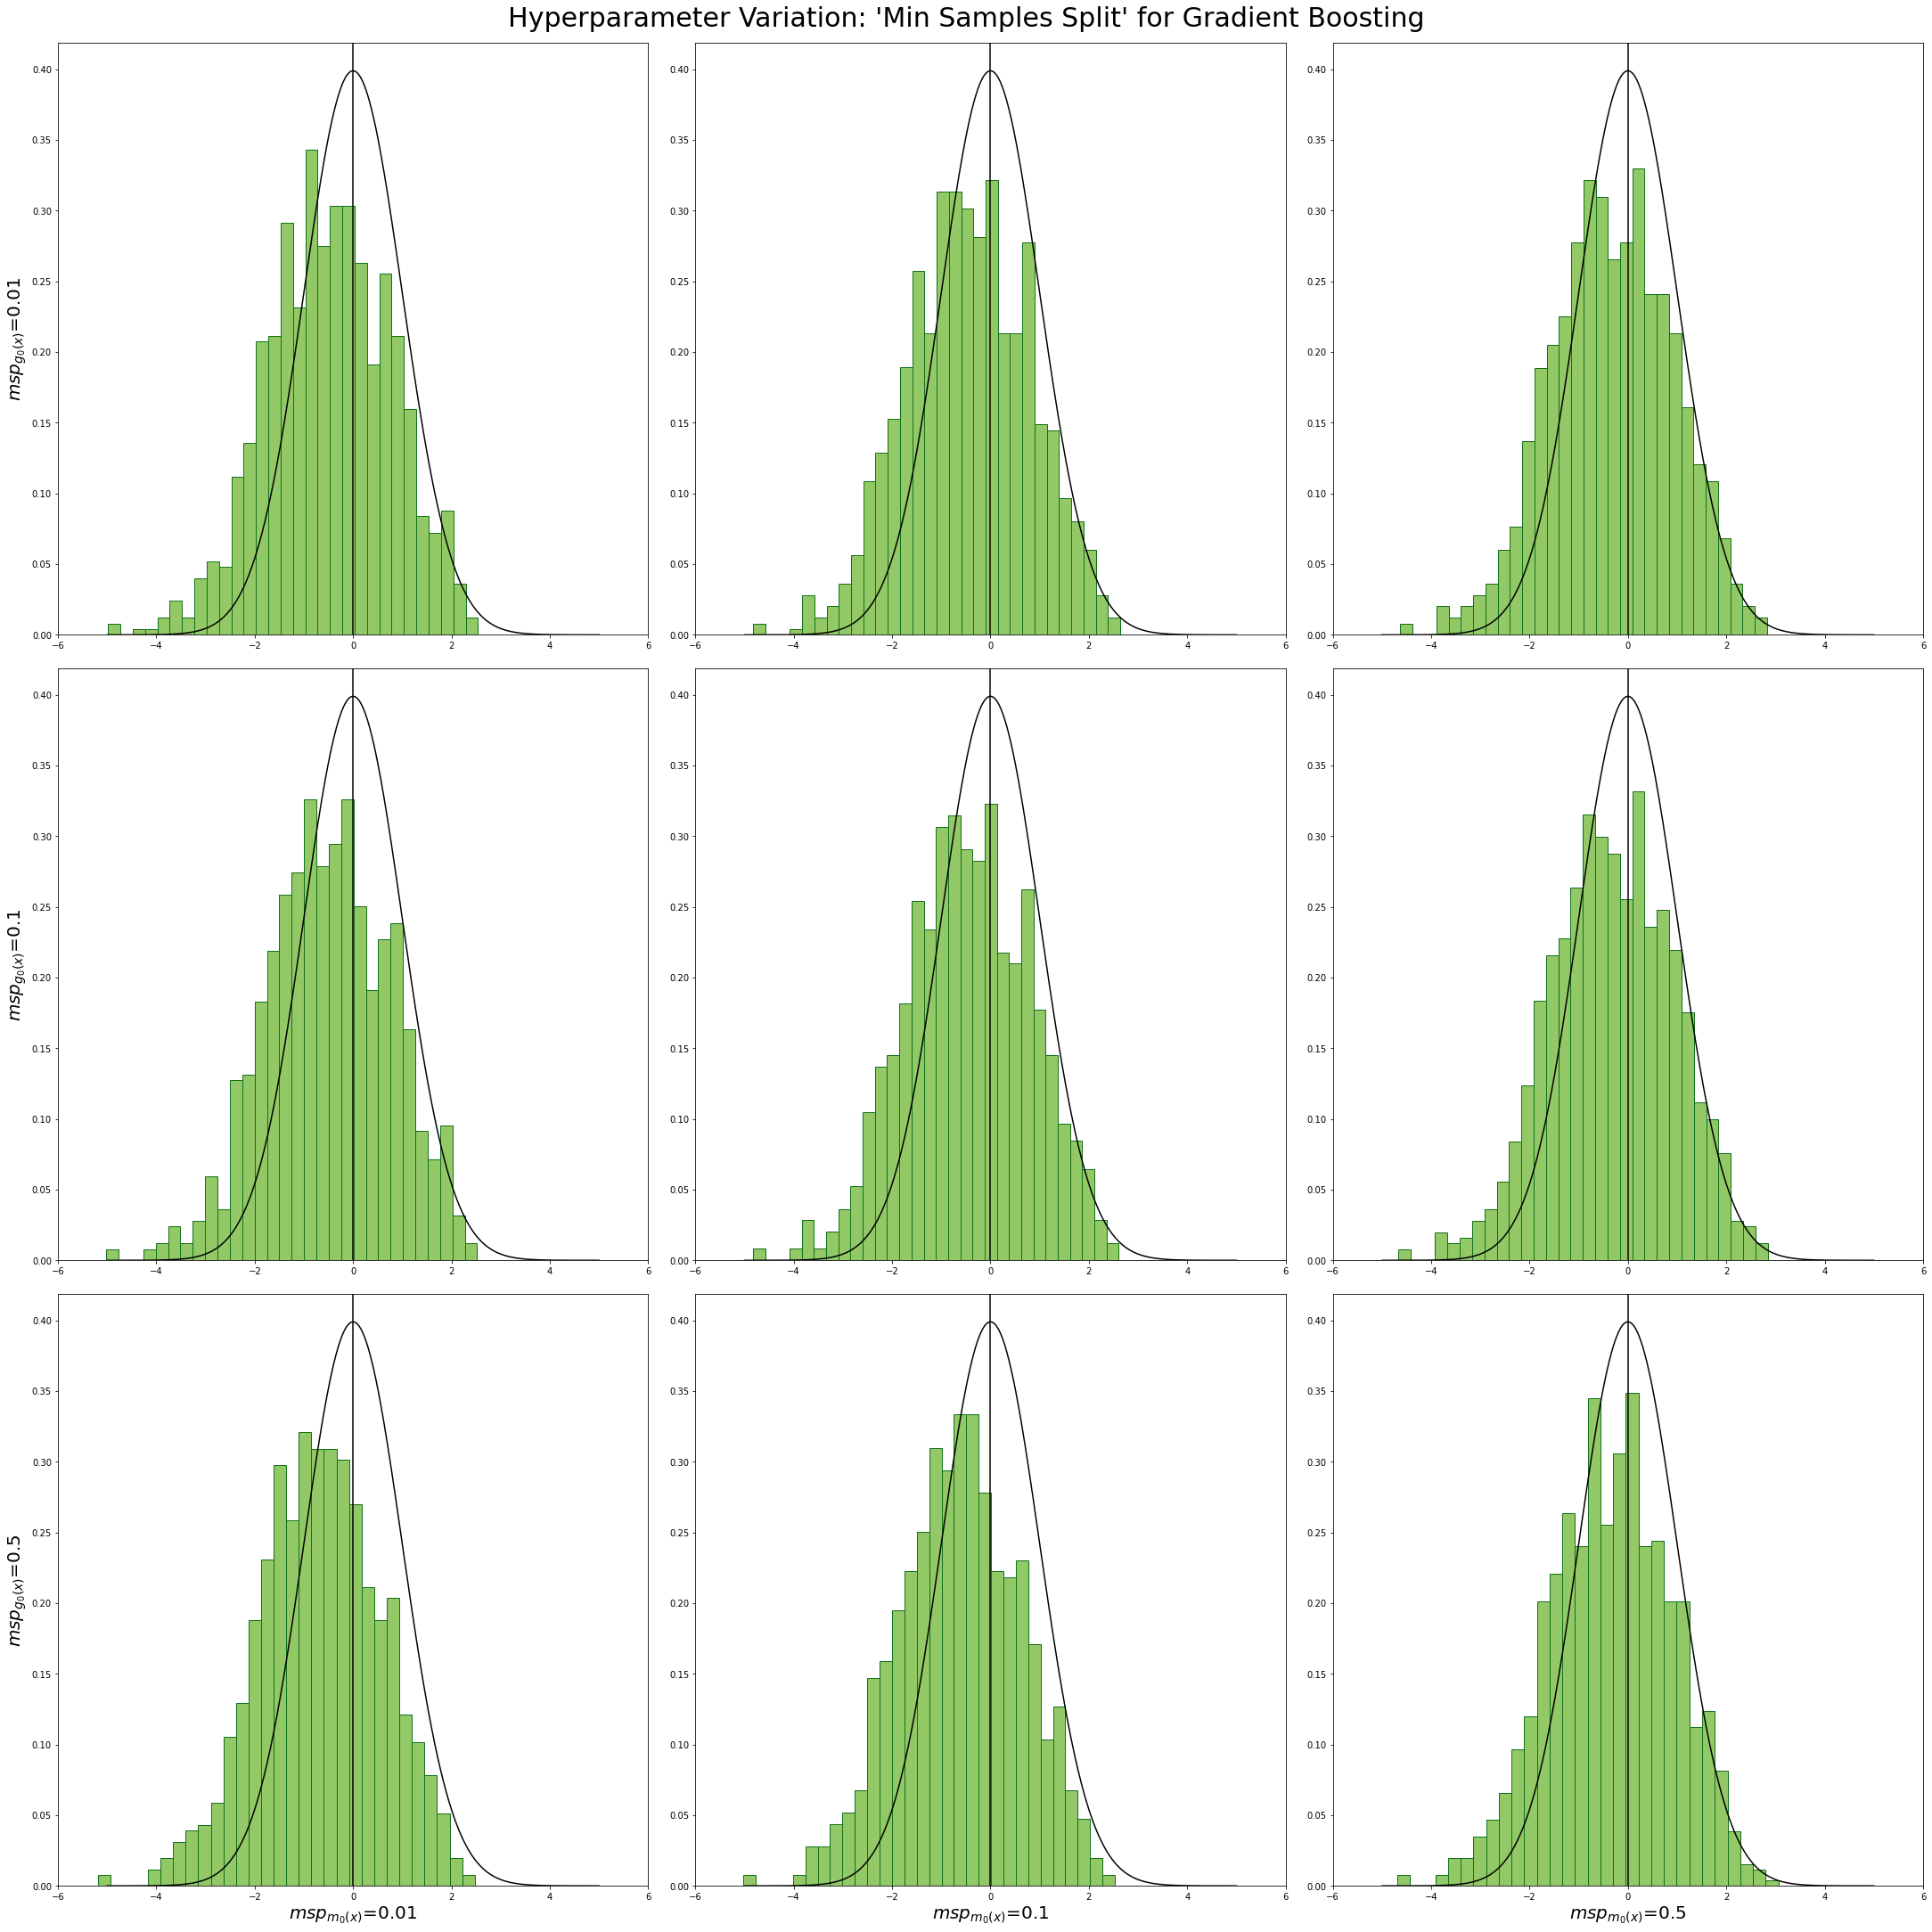

In [10]:
face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

gb_min_samples_split_hyperparams_ml_l = [0.01, 0.1, 0.5]
gb_min_samples_split_hyperparams_ml_m = [0.01, 0.1, 0.5]
n_folds = 2

scores = []
distributions_calculated = 1

fig, axs = plt.subplots(len(gb_min_samples_split_hyperparams_ml_l), len(gb_min_samples_split_hyperparams_ml_m), 
                        figsize=(10*len(gb_min_samples_split_hyperparams_ml_l), 10*len(gb_min_samples_split_hyperparams_ml_m)), 
                        constrained_layout=True)

fig.suptitle("Hyperparameter Variation: 'Min Samples Split' for Gradient Boosting", fontsize=30)

for ml_l_param in gb_min_samples_split_hyperparams_ml_l:
    for ml_m_param in gb_min_samples_split_hyperparams_ml_m:

        i_m = gb_min_samples_split_hyperparams_ml_m.index(ml_m_param)
        i_l = gb_min_samples_split_hyperparams_ml_l.index(ml_l_param)

        ml_l = clone(ml_l_plr_gb_model).set_params(**{'min_samples_split': ml_l_param})
        ml_m = clone(ml_m_plr_gb_model).set_params(**{'min_samples_split': ml_m_param})
        
        theta_scores, se_scores, _ = simulate_gb_plr(ml_l=ml_l, ml_m=ml_m, n_folds=n_folds, data=data, score='partialling out')

        scores.append((theta_scores, se_scores, f"ml_l-min_samples_split: {ml_l_param}", f"ml_m-min_samples_split: {ml_m_param}"))

        print(f"Distributions calculated: {distributions_calculated}")
        
        axs[i_l, i_m].hist((theta_scores - alpha)/se_scores,
                            color=face_colors[2], edgecolor = edge_colors[2],
                            density=True, bins=30, label='Double ML Gradient Boosting')
        axs[i_l, i_m].axvline(0., color='k')
        axs[i_l, i_m].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
        #axs[i_l, i_m].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        axs[len(gb_min_samples_split_hyperparams_ml_l)-1, i_m].set_xlabel('$msp_{m_{0}(x)}$=' + f'{ml_m_param}', fontsize=20)
        axs[i_l, 0].set_ylabel('$msp_{g_{0}(x)}$=' + f'{ml_l_param}', fontsize=20)
        axs[i_l, i_m].set_xlim([-6., 6.])

        distributions_calculated += 1

plt.savefig("plots/gb_min_samples_split_variation.png", facecolor="white")

## 3.3 Learning Rate Variation

Distributions calculated: 1
Distributions calculated: 2
Distributions calculated: 3
Distributions calculated: 4
Distributions calculated: 5
Distributions calculated: 6
Distributions calculated: 7
Distributions calculated: 8
Distributions calculated: 9


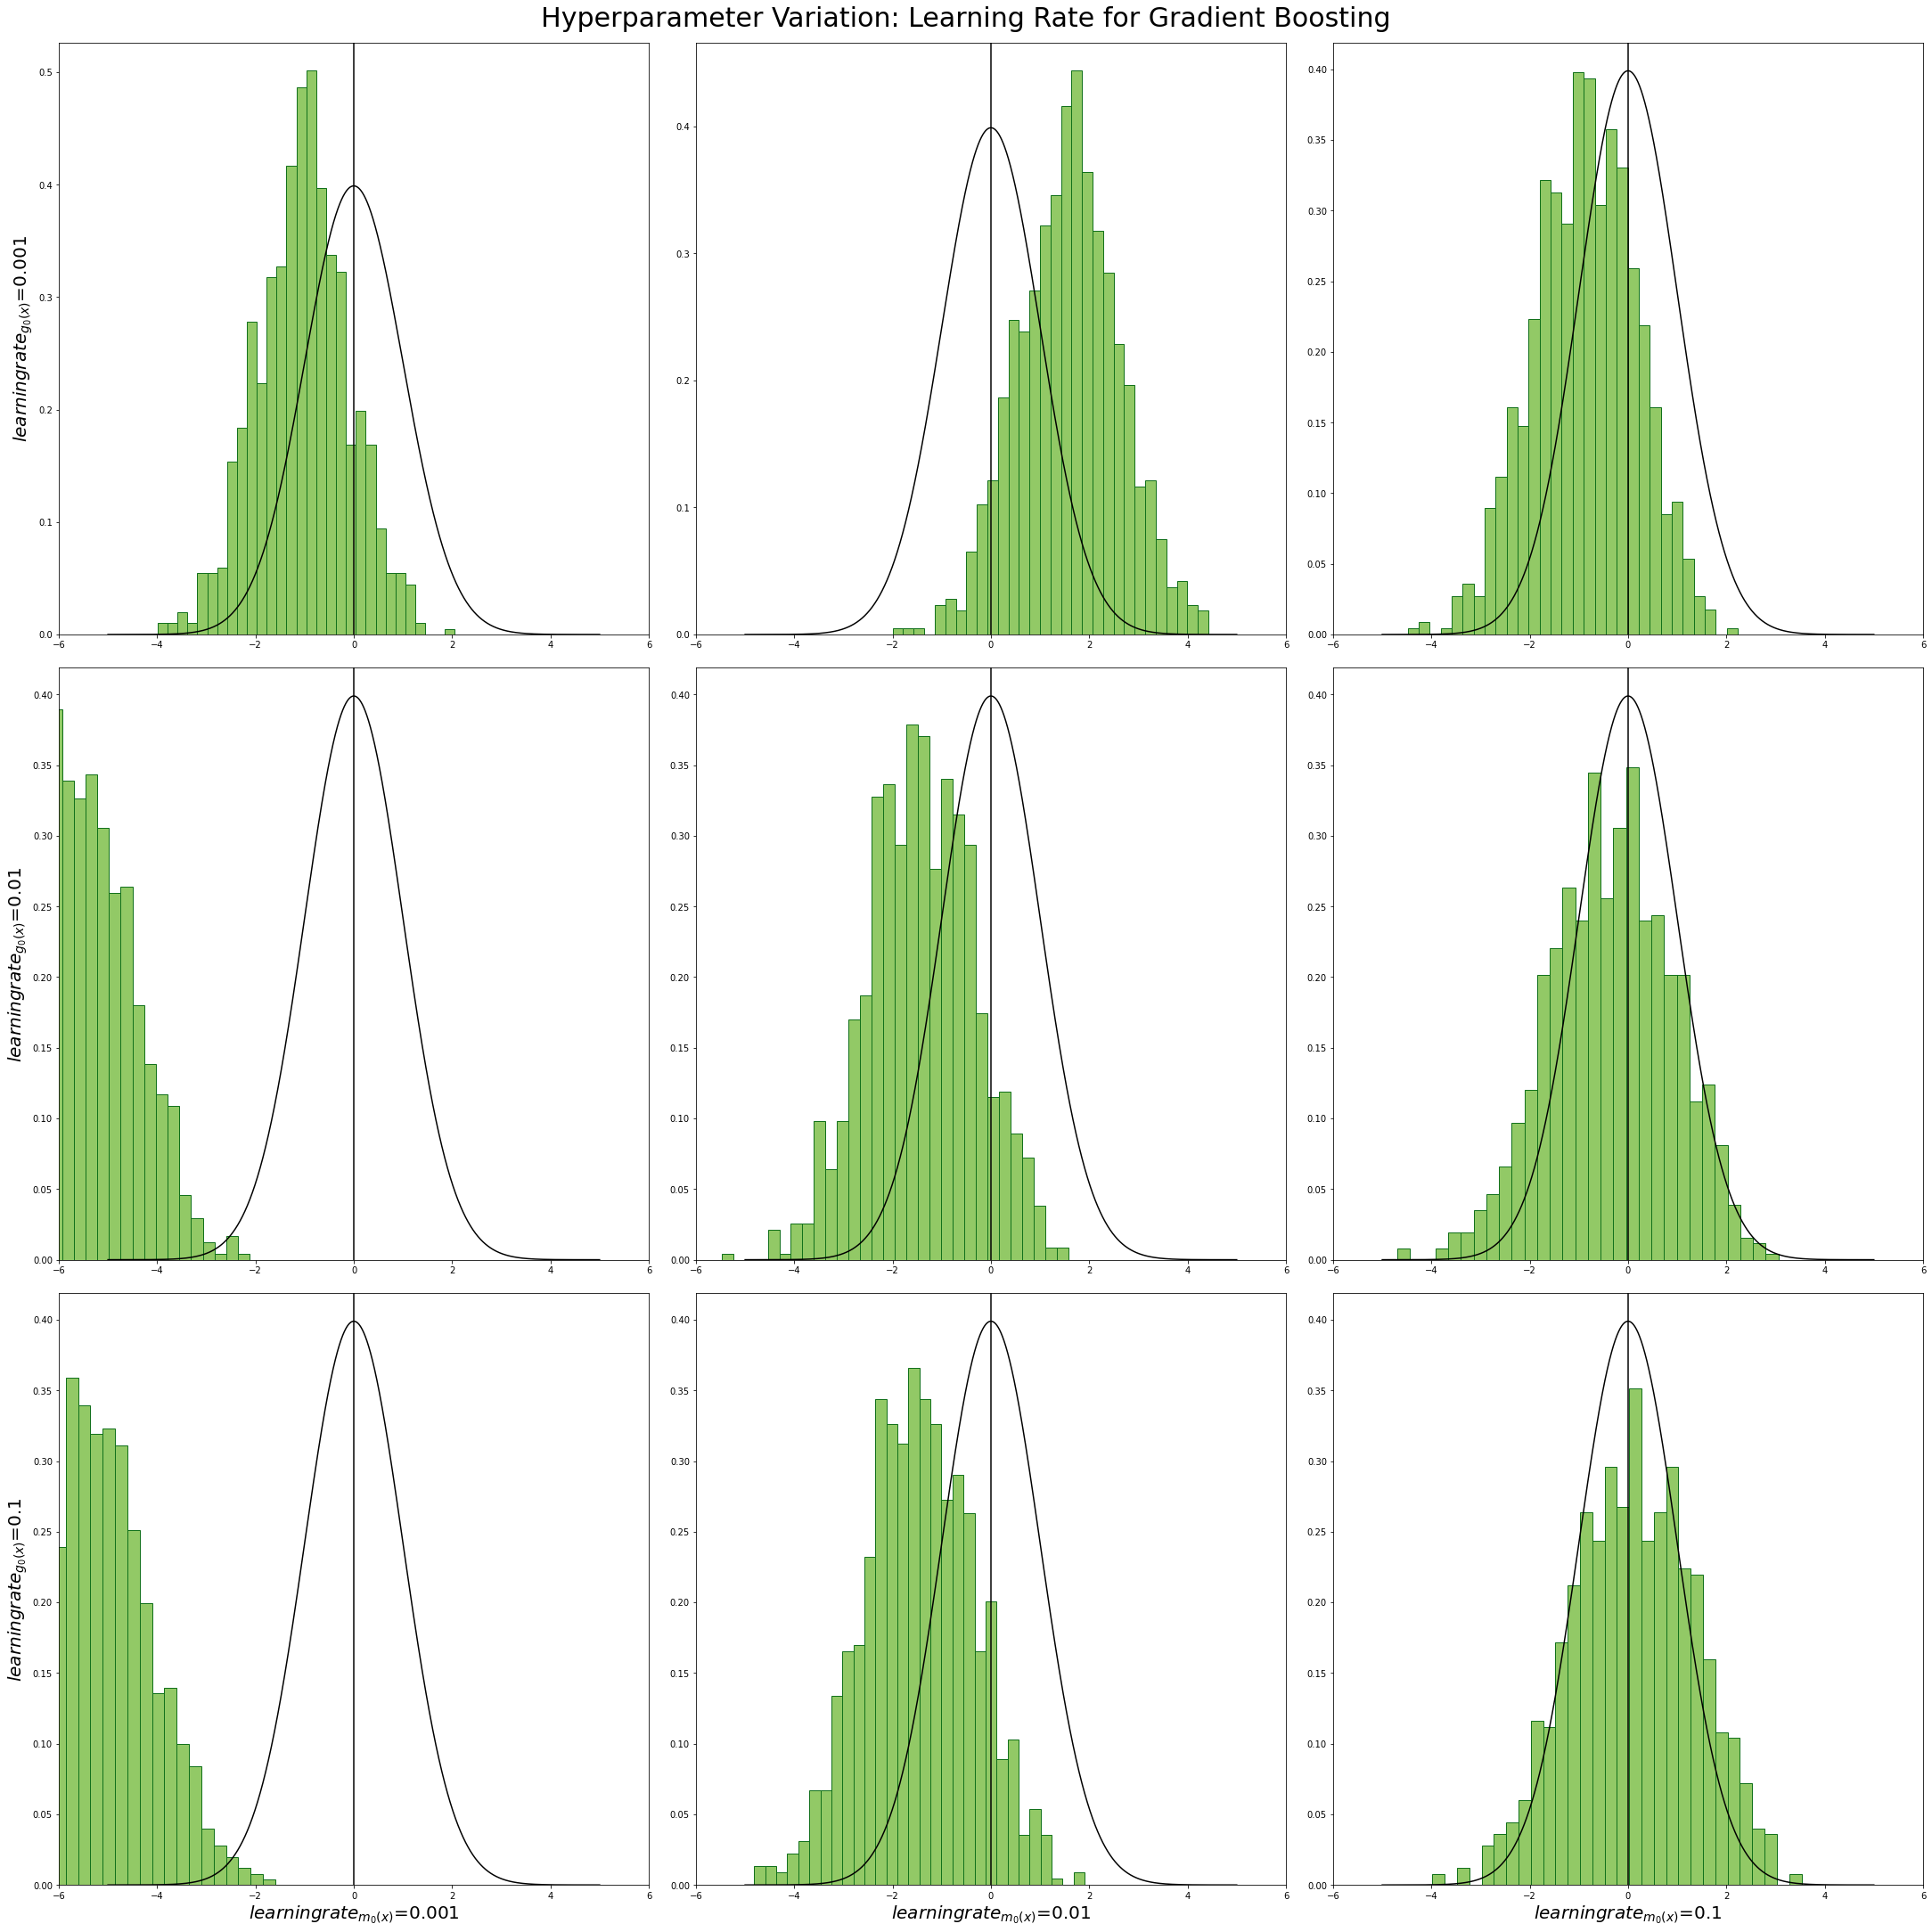

In [11]:
face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

gb_learning_rate_hyperparams_ml_l = [0.001, 0.01, 0.1]
gb_learning_rate_hyperparams_ml_m = [0.001, 0.01, 0.1]
n_folds = 2

scores = []
distributions_calculated = 1

fig, axs = plt.subplots(len(gb_learning_rate_hyperparams_ml_l), len(gb_learning_rate_hyperparams_ml_m), 
                        figsize=(10*len(gb_learning_rate_hyperparams_ml_l), 10*len(gb_learning_rate_hyperparams_ml_m)), 
                        constrained_layout=True)

fig.suptitle("Hyperparameter Variation: Learning Rate for Gradient Boosting", fontsize=30)

for ml_l_param in gb_learning_rate_hyperparams_ml_l:
    for ml_m_param in gb_learning_rate_hyperparams_ml_m:

        i_m = gb_learning_rate_hyperparams_ml_m.index(ml_m_param)
        i_l = gb_learning_rate_hyperparams_ml_l.index(ml_l_param)

        ml_l = clone(ml_l_plr_gb_model).set_params(**{'learning_rate': ml_l_param})
        ml_m = clone(ml_m_plr_gb_model).set_params(**{'learning_rate': ml_m_param})
        
        theta_scores, se_scores, _ = simulate_gb_plr(ml_l=ml_l, ml_m=ml_m, n_folds=n_folds, data=data, score='partialling out')

        scores.append((theta_scores, se_scores, f"ml_l-lr: {ml_l_param}", f"ml_m-lr: {ml_m_param}"))

        print(f"Distributions calculated: {distributions_calculated}")
        
        axs[i_l, i_m].hist((theta_scores - alpha)/se_scores,
                            color=face_colors[2], edgecolor = edge_colors[2],
                            density=True, bins=30, label='Double ML Gradient Boosting')
        axs[i_l, i_m].axvline(0., color='k')
        axs[i_l, i_m].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
        #axs[i_l, i_m].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        axs[len(gb_learning_rate_hyperparams_ml_l)-1, i_m].set_xlabel('$learningrate_{m_{0}(x)}$=' + f'{ml_m_param}', fontsize=20)
        axs[i_l, 0].set_ylabel('$learningrate_{g_{0}(x)}$=' + f'{ml_l_param}', fontsize=20)
        axs[i_l, i_m].set_xlim([-6., 6.])

        distributions_calculated += 1

plt.savefig("plots/gb_learning_rate_variation.png", facecolor="white")

# 4. IRM Simulation and Hyperparameter Variation